In [1]:
from transfer_em.datasets import datasets, generators
from transfer_em.debug import generate_images
from transfer_em.cgan import EM2EM
from transfer_em import debug

import tensorflow as tf
import time

### Setup input and output domain datasets for training and testing

In [4]:
# location of service front-end to ng precomputed
cloudrun = "https://transferem-bmcp5imp6q-uk.a.run.app"

# create dataset of 3D datasets from two datasets stored in neuroglancer's precomputed format (assume gcs location)
dataset_x_location = "neuroglancer-janelia-flyem-hemibrain/emdata/raw/jpeg"

# use a dataset with a different contrast adjustment
dataset_y_location = "neuroglancer-janelia-flyem-hemibrain/emdata/clahe_yz/jpeg"

# crude bbox for hemibrain
bbox = ((8000, 14000, 13000), (30000, 28000, 25000)) # x,y,z, x2,y2,z2

# 132x132x132 cube is minimum allowable size (use small batches)
generator = generators.volume3d_ng(dataset_x_location, bbox, 132, cloudrun=cloudrun)

# will take some time to download the whole dataset for the first time; just do a really small epoch size of 2
start = time.time()
train_x, meanstd_x = datasets.create_dataset_from_generator(generator, (132,132,132), batch_size=1, epoch_size=2)
print(time.time() - start)

# keep track of this when running inference
print(f"meanstd_x: {meanstd_x}")

# 132x132x132 cube is minimum allowable size (use small batches)
generator = generators.volume3d_ng(dataset_y_location, bbox, 132, cloudrun=cloudrun)
train_y, meanstd_y = datasets.create_dataset_from_generator(generator, (132,132,132), batch_size=1, epoch_size=2)

# keep track of this when running inference
print(f"meanstd_y: {meanstd_y}")


KeyboardInterrupt: 

In [5]:
# create a test set for evaluation -- set seed to get same sequence

generator = generators.volume3d_ng(dataset_y_location, bbox, 132, seed=10, cloudrun=cloudrun)
test_x, _ = datasets.create_dataset_from_generator(generator, (132,132,132), batch_size=1, epoch_size=1, meanstd=meanstd_x)


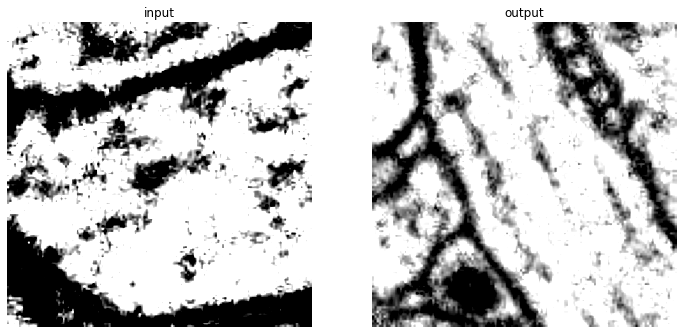

In [4]:
# get a sample from the test dataset and view
sample = next(iter(test_x))
sample_target = next(iter(train_y))

generate_images(sample, sample_target)

### Create model and test (saves checkpoints)

In [5]:
# create EM2EM network with 132x132 image and provide an experiment name for checkpointing
em2em = EM2EM(132, "hemi2hemi_1", is3d=True)

In [6]:
# train for 1 EPOCH
em2em.train(train_x, train_y, 1, 0, False, num_samples=2)

  0%|          | 2/4096 [20:33<701:32:55, 616.90s/it]


Saving checkpoint for epoch 1 at ./checkpoints/train_hemi2hemi_1/ckpt-1
Time taken for epoch 1 is 1243.3185529708862


### Run inference directly using the model

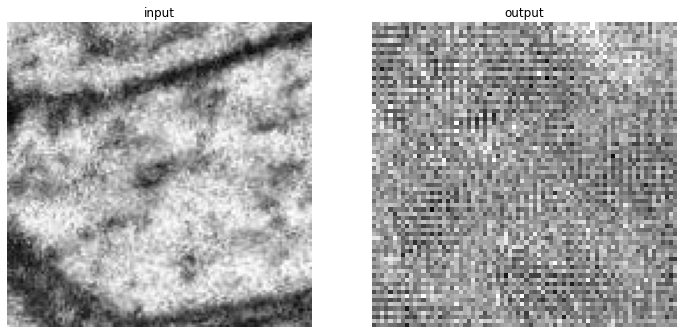

In [8]:
# run prediction on the sample (64 image batch)
sample_pred = em2em.predict(sample)

# rescale based on f's meanstd
sample_unstd = datasets.unstandardize_population(sample, meanstd_x)

# rescale prediction based on g's meanstd
sample_pred_unstd = datasets.unstandardize_population(sample_pred, meanstd_y)

# view final results
generate_images(sample_unstd, sample_pred_unstd)

### Run inference using prediction utility

* reload model from a given checkpoint
* run inference for a large cube

In [5]:
from transfer_em.utils import predict_ng_cube

# read first checkpoint (TODO: allow user to not require re-adding EM2EM parameters)
model = EM2EM(132, "hemi2hemi_1", is3d=True, ckpt_restore="./checkpoints/train_hemi2hemi_1/ckpt-1")

# utility will take care of chunking the request
test_in, test_out = predict_ng_cube(dataset_x_location, (8000, 14000, 13000), (120, 120, 120),
                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)

checkpoint ./checkpoints/train_hemi2hemi_1/ckpt-1 restored
Latest checkpoint restored!!


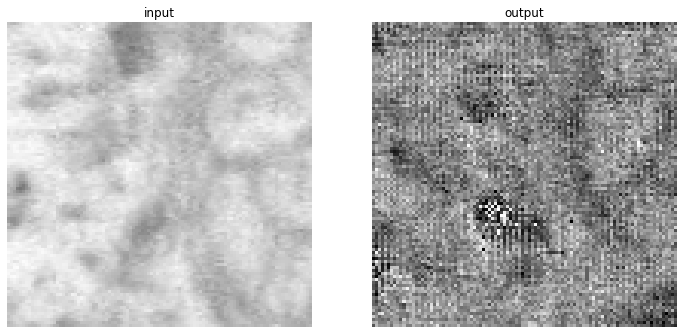

In [4]:
# view results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))                                                                                       
plt.subplot(121)
plt.title("input")
plt.imshow(test_in[:,:,50], cmap="gray", vmin=0, vmax=255)                                                            
plt.axis('off')
plt.subplot(122)
plt.title("output")
plt.imshow(test_out[:,:,0], cmap="gray", vmin=0, vmax=255)                                                            
plt.axis('off')
plt.show() 